# **Soft Computing Project**

> **Tuning of Fuzzy Logic with the help of Genetic Algorithm**

> Presented By: 

*   Abhigyan Srivastava (18064001)
*   Divya Sinha (18084007)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn import datasets
from tqdm import tqdm
!pip install -U scikit-fuzzy
import skfuzzy as fuzz

     |████████████████████████████████| 1.0MB 6.2MB/s 
  Created wheel for scikit-fuzzy: filename=scikit_fuzzy-0.4.2-cp37-none-any.whl size=894069 sha256=7db579d69531051959a61cf278a70d33a8038c3e2e55625399c927d5937608f2
  Stored in directory: /root/.cache/pip/wheels/b9/4e/77/da79b16f64ef1738d95486e2731eea09d73e90a72465096600
Successfully built scikit-fuzzy


# **Genetic Algorithm**

In [ ]:
def _best(population, fitness_func, best, fbest):

    for i in range(population[0].shape[0]):
        if population[1][i] > -1.0:
            tmp = population[1][i]
        else:
            tmp = fitness_func(population[0][i])
            population[1][i] = tmp

        if best is None or tmp < fbest:
            best = population[0][i]
            fbest = tmp
    return best.copy(), fbest.copy()

def _tournament_selection(population, fitness_func):

    idxs = np.random.permutation(np.arange(population[0].shape[0]))

    parent1 = population[0][idxs[0], :]
    parent2 = population[0][idxs[1], :]

    if population[1][idxs[0]] > -1.0:
        fitness1 = population[1][idxs[0]] 
    else:
        fitness1 = fitness_func(parent1)
        population[1][idxs[0]] = fitness1

    if population[1][idxs[1]] > -1.0:
        fitness2 = population[1][idxs[1]] 
    else:
        fitness2 = fitness_func(parent2)
        population[1][idxs[1]] = fitness2

    return parent1 if fitness1 < fitness2 else parent2


def individuals(size):  # Return index of random attribute of an individual 
    return np.random.rand(size)


# Function that mutates an individual
def _mutate(individual):

    idx = np.random.randint(low=0, high=individual.shape[0])
    individual[idx] = np.random.rand()
    return individual

def _crossover(male, female, alpha=0.7):
  
    shift = np.abs(male - female) * alpha

    mmin = np.amin([male, female], axis=0) - shift
    mmax = np.amax([male, female], axis=0) + shift

    mmin = np.clip(mmin, 0, 1)
    mmax = np.clip(mmax, 0, 1)

    offspring1 = np.random.uniform(low=mmin, high=mmax)
    offspring2 = np.random.uniform(low=mmin, high=mmax)

    return offspring1, offspring2  


def genetic_algorithm(fitness_func, dim, n_individuals, epochs, crossover_rate, mutation_rate, verbose):
    
    assert n_individuals % 2 == 0
    
    population = [np.array([individuals(dim) for x in range(n_individuals)]), 
                  np.zeros(n_individuals) - 1.0]

    children = np.zeros((n_individuals, dim)) # 10 x 4 
    best, fbest = None, None

    for e in range(epochs):
        for c in range(0, n_individuals, 2):

            parent1 = _tournament_selection(population, fitness_func)
            parent2 = _tournament_selection(population, fitness_func)

            while np.array_equal(parent1, parent2):
                parent2 = _tournament_selection(population, fitness_func)

            if np.random.uniform() < crossover_rate:
                offspring1, offspring2 = _crossover(parent1, parent2)
                children[c, :] = offspring1
                children[c+1, :] = offspring2
            else:
                children[c, :] = parent1
                children[c+1, :] = parent2

            if np.random.uniform() < mutation_rate:
                children[c, :] = _mutate(children[c, :])

            if np.random.uniform() < mutation_rate:
                children[c+1, :] = _mutate(children[c+1, :])

        best, fbest = _best(population, fitness_func, best, fbest)

        population[0][:] = children[:]
        population[1][:] = -1.0
        children[:] = 0.0

        if verbose:
            print('epoch {:2d}, best fitness = {:.10f}'.format(e, fbest))

    return best, fbest

# **Fuzzy Logic**

In [ ]:
def normalize_dataset(dataset):
	min_arr = np.amin(dataset, axis=0)
	return (dataset - min_arr) / (np.amax(dataset, axis=0) - min_arr)

def evaluate_new_fuzzy_system(w1, w2, w3, w4, data, target):
  
  universe = np.linspace(0, 1, 150)

  x = []
  for w in [w1, w2, w3, w4]: # 4 membership functions, 1 for each wi
    x.append({'s': fuzz.trimf(universe, [0.0, 0.0, w]),
              'm': fuzz.trimf(universe, [0.0, w, 1.0]),
            'l': fuzz.trimf(universe, [w, 1.0, 1.0])})

  x_memb = []
  for i in range(4):
    x_memb.append({})
    for t in ['s', 'm', 'l']:
      x_memb[i][t] = fuzz.interp_membership(universe, x[i][t], data[:, i])

  is_setosa = np.fmin(np.fmax(x_memb[2]['s'], x_memb[2]['m']), x_memb[3]['s'])
  is_versicolor = np.fmax(np.fmin(np.fmin(np.fmin(np.fmax(x_memb[0]['s'], x_memb[0]['l']), np.fmax(x_memb[1]['m'], x_memb[1]['l'])), np.fmax(x_memb[2]['m'], x_memb[2]['l'])),x_memb[3]['m']), np.fmin(x_memb[0]['m'], np.fmin(np.fmin(np.fmax(x_memb[1]['s'], x_memb[1]['m']),x_memb[2]['s']), x_memb[3]['l'])))
  is_virginica = np.fmin(np.fmin(np.fmax(x_memb[1]['s'], x_memb[1]['m']), x_memb[2]['l']), x_memb[3]['l'])

  result = np.argmax([is_setosa, is_versicolor, is_virginica], axis=0)

  return (result == target).mean()

# **Model Training & Testing**

100%|██████████| 30/30 [00:09<00:00,  3.10it/s]

 THE ACCURACY ACHIEVED IS  0.952


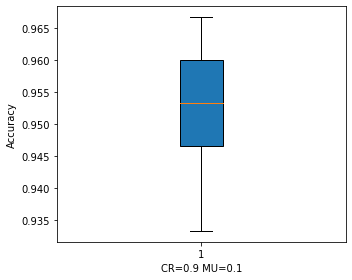

In [ ]:
iris = datasets.load_iris()
normalized_iris = normalize_dataset(iris.data)
n_features = normalized_iris.shape[1] # features/attributes  = 4

fitness = lambda w: 1.0 - evaluate_new_fuzzy_system(w[0], w[1], w[2], w[3], normalized_iris, iris.target)

cr_rate = 0.9
mu_rate = 0.1

fitness_record = []
for i in tqdm(range(30)):

  best, fbest = genetic_algorithm(fitness_func=fitness, dim=n_features, n_individuals=10, epochs=30, crossover_rate=cr_rate, mutation_rate=mu_rate, verbose=False)
  fitness_record.append(1.0 - fbest)

acc = sum(fitness_record)/len(fitness_record)
print (" THE ACCURACY ACHIEVED IS " , acc) 

fig, ax = plt.subplots(figsize=(5, 4))

ax.boxplot(fitness_record, vert=True, patch_artist=True)

s = 'CR='+str(cr_rate)+' MU='+str(mu_rate)
ax.set_xlabel(s)
ax.set_ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [ ]:
min_acc = min(fitness_record)
max_acc = max(fitness_record)
mean_acc = sum(fitness_record)/len(fitness_record)
import statistics
std = statistics.pstdev(fitness_record)
print("Minimum accuracy achieved is: " + str(min_acc))
print("Maximum accuracy achieved is: " + str(max_acc))
print("Average accuracy is: " + str(mean_acc))
print("Standard deviation is : " + str(std))

Minimum accuracy achieved is: 0.9333333333333333
Maximum accuracy achieved is: 0.9666666666666667
Average accuracy is: 0.952
Standard deviation is : 0.009645570850760312


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


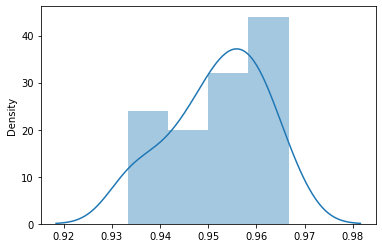

In [ ]:
import seaborn as sns
sns.distplot(fitness_record)